In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import copy
from sklearn.impute import SimpleImputer

%matplotlib inline
pd.options.mode.chained_assignment = None



In [2]:
#df = pd.read_csv('fully_processed_reddit_data_cleaned1.csv')
#no sentiment data set
#df = pd.read_csv('fully_processed_reddit_data_cleaned1.csv')

#sentiment data set
df = pd.read_csv('updated_fully_processed_reddit_data_cleaned1.csv')

# X = df.drop(['house_cost'],axis=1).to_numpy()
# Y = df['house_cost'].to_numpy()
#print length of data
print(len(df))
df.head()




10707


,authorMod,authorKarma,Num_Comments,Subreddit_Subcribers,Score,Ratio,NSFW,Spoiler,Awards,Created_UTC,...,Class_love,Class_nervousness,Class_optimism,Class_pride,Class_realization,Class_relief,Class_remorse,Class_sadness,Class_suprise,Class_neutral
0,0.0,14,3.0,499719.0,1.0,1.00,0.0,0.0,0,2021-02-01 11:21:48,...,0.027922,0.012384,0.030525,0.012625,0.023377,0.016472,0.039398,0.056775,0.031668,0.105605
1,0.0,21742,2.0,11526.0,2.0,1.00,0.0,0.0,0,2024-10-02 23:57:11,...,0.024714,0.005187,0.014965,0.004392,0.012675,0.005491,0.007280,0.013266,0.013262,0.192386
2,1.0,10720,4.0,31006.0,3.0,0.71,0.0,0.0,0,2024-10-19 10:40:21,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.0,884,0.0,364919.0,1.0,1.00,0.0,0.0,0,2024-08-25 22:31:46,...,0.039824,0.006173,0.023703,0.007602,0.016182,0.009648,0.015850,0.022776,0.020582,0.086709
4,0.0,93,125.0,378170.0,52.0,0.90,0.0,0.0,0,2022-01-14 21:15:32,...,0.056375,0.014495,0.039951,0.019795,0.025123,0.016429,0.030830,0.045656,0.027279,0.087232


In [3]:
print(df.columns)

#probably noramized score depends on score so will drop for now  (and to double check with group)
df = df.drop(['Normalized_Score'],axis=1)

#Now we want to do a hot econding of the Day_of_Week column 
df = pd.get_dummies(df, columns=['Day_of_Week'], drop_first=True)

#Also want to do a hot encoding of the 'Media_Type' column
df = pd.get_dummies(df, columns=['Media_Type'], drop_first=True)

#now want to change the "Created_UTC" column data from 
df['Created_UTC'] = pd.to_datetime(df['Created_UTC'])

#for 'Created_UTC' column will extract the year, month, day, hour, minute, second then drop the original column
df['Year'] = df['Created_UTC'].dt.year
df['Month'] = df['Created_UTC'].dt.month
df['Day'] = df['Created_UTC'].dt.day
df['Hour'] = df['Created_UTC'].dt.hour
df['Minute'] = df['Created_UTC'].dt.minute
df['Second'] = df['Created_UTC'].dt.second
df = df.drop(['Created_UTC'],axis=1)

#'Has_Media' column is boolean so will convert to int
df['Has_Media'] = df['Has_Media'].astype(int)

#'Awards' column does not look good so will drop
df = df.drop(['Awards'],axis=1)

#'

#'Enagement_Rate' has infinite values so will drop for now (also might be correlated with score/comments?)
df = df.drop(['Engagement_Rate'],axis=1)

# Convert all columns in the DataFrame to numeric, coercing invalid entries to NaN
df = df.apply(pd.to_numeric, errors='coerce')

df.head()


Index(['authorMod', 'authorKarma', 'Num_Comments', 'Subreddit_Subcribers',
       'Score', 'Ratio', 'NSFW', 'Spoiler', 'Awards', 'Created_UTC',
       'Day_of_Week', 'Hour_of_Day', 'Is_Weekend', 'Title_Character_Count',
       'Title_Word_Diversity', 'Title_Punctuation_Count', 'Title_Has_Question',
       'Text_Character_Count', 'Text_Word_Diversity', 'Text_Punctuation_Count',
       'Text_Has_Question', 'Has_Media', 'Media_Type', 'Engagement_Rate',
       'Normalized_Score', 'Is_Popular_Subreddit', 'Class_admiration',
       'Class_amusment', 'Class_anger', 'Class_annoyance', 'Class_approval',
       'Class_caring', 'Class_confusion', 'Class_curiousity', 'Class_desire',
       'Class_dissapointment', 'Class_disaproval', 'Class_disgust',
       'Class_embarrassment', 'Class_excitement', 'Class_fear',
       'Class_gratitude', 'Class_grief', 'Class_joy', 'Class_love',
       'Class_nervousness', 'Class_optimism', 'Class_pride',
       'Class_realization', 'Class_relief', 'Class_remorse'

,authorMod,authorKarma,Num_Comments,Subreddit_Subcribers,Score,Ratio,NSFW,Spoiler,Hour_of_Day,Is_Weekend,...,Day_of_Week_Tuesday,Day_of_Week_Wednesday,Media_Type_none,Media_Type_video,Year,Month,Day,Hour,Minute,Second
0,0.0,14,3.0,499719.0,1.0,1.00,0.0,0.0,11.0,0,...,0,0,1,0,2021.0,2.0,1.0,11.0,21.0,48.0
1,0.0,21742,2.0,11526.0,2.0,1.00,0.0,0.0,23.0,0,...,0,1,1,0,2024.0,10.0,2.0,23.0,57.0,11.0
2,1.0,10720,4.0,31006.0,3.0,0.71,0.0,0.0,10.0,1,...,0,0,1,0,2024.0,10.0,19.0,10.0,40.0,21.0
3,0.0,884,0.0,364919.0,1.0,1.00,0.0,0.0,22.0,1,...,0,0,1,0,2024.0,8.0,25.0,22.0,31.0,46.0
4,0.0,93,125.0,378170.0,52.0,0.90,0.0,0.0,21.0,0,...,0,0,1,0,2022.0,1.0,14.0,21.0,15.0,32.0


In [9]:
print(df.columns)

Index(['authorMod', 'authorKarma', 'Num_Comments', 'Subreddit_Subcribers',
       'Ratio', 'NSFW', 'Spoiler', 'Hour_of_Day', 'Is_Weekend',
       'Title_Character_Count', 'Title_Word_Diversity',
       'Title_Punctuation_Count', 'Title_Has_Question', 'Text_Character_Count',
       'Text_Word_Diversity', 'Text_Punctuation_Count', 'Text_Has_Question',
       'Has_Media', 'Is_Popular_Subreddit', 'Class_admiration',
       'Class_amusment', 'Class_anger', 'Class_annoyance', 'Class_approval',
       'Class_caring', 'Class_confusion', 'Class_curiousity', 'Class_desire',
       'Class_dissapointment', 'Class_disaproval', 'Class_disgust',
       'Class_embarrassment', 'Class_excitement', 'Class_fear',
       'Class_gratitude', 'Class_grief', 'Class_joy', 'Class_love',
       'Class_nervousness', 'Class_optimism', 'Class_pride',
       'Class_realization', 'Class_relief', 'Class_remorse', 'Class_sadness',
       'Class_suprise', 'Class_neutral', 'Day_of_Week_Monday',
       'Day_of_Week_Saturda

In [4]:
# X=df.drop(['Score'],axis=1).to_numpy()
# Y=df['Score'].to_numpy()

#instead of predicting score will predict 'Num_Comments'
#and will drop 'Score' column
df=df.drop(['Score'],axis=1)
X=df.drop(['Num_Comments'],axis=1).to_numpy()
Y=df['Num_Comments'].to_numpy()


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


# Replace infinite values with NaN
X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan


# #impute nan values with mean 
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Impute NaN values in Y_train with mean
imputer_y = SimpleImputer(strategy='mean')
Y_train = imputer_y.fit_transform(Y_train.reshape(-1, 1)).flatten()
Y_test = imputer_y.transform(Y_test.reshape(-1, 1)).flatten()

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


#X[1]
#type(df['Media_Type'][1])
#df['Created_UTC'][1]

In [5]:
#Convert the numpy arrays to torch tensors. Make sure that the tensors are of dtype torch.float32. 
# Also make sure that the target tensors (y) are 2-dimensional by using .reshape(-1,1) on the tensors.

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32).reshape(-1,1)
Y_test = torch.tensor(Y_test, dtype=torch.float32).reshape(-1,1)


In [6]:
def eval(model, X, y):
    model.eval()
    ##  START CODE  ##
    y_pred = model(X)
    y_pred_np = y_pred.detach().cpu().numpy()
    y_true_np = y.detach().cpu().numpy()
    mse = mean_squared_error(y_true_np, y_pred_np)
    r2 = r2_score(y_true_np, y_pred_np)
    ##  END CODE  ##
    return mse, r2

In [7]:
#we will want to treat the number of epochs as a hyperparameter so will write a function that trains the model for a given number of epochs for training and validation data sets

#first let us split our trainig data into training and validation sets
#we will use 80% of the data for training and 20% for validation

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

#next we want to write a function that trains the model for a given number of epochs and keeps track of the loss at each epcch for both the training and validation data sets to make a learning curve

def train_model(model, X_train, Y_train, X_val, Y_val, n_epochs=100, lr=0.01, batch_size=64, loss_fn=nn.MSELoss(), optimizer=optim.Adam):
    model.train() # set model to training mode
    best_mse= np.inf #initialize best_mse to infinity
    best_r2= -np.inf #initialize best_r2 to negative infinity
    best_weights = None #initialize best_weights to None
    best_epoch = 0 #initialize best_epoch to 0
    train_history= []
    val_history = []
    batch_start =torch.arange(0, len(X_train), batch_size) #create a tensor with the indices of the start of each batch

    for epoch in range(n_epochs):
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar: #create a progress bar for the batches. unit means that the unit of the progress bar is "batch". mininterval is the minimum time between updates of the progress bar. disable=False means that the progress bar is enabled.
            bar.set_description(f"Epoch {epoch}")
            train_losses = [] #initialize an empty list to store the training losses
            for start in bar: #iterate over the start of each batch
                #take a batch of data with help of start variable
                end=min(start+batch_size, len(X_train)) #calculate the end of the batch
                X_batch = X_train[start:end] #take a batch of X
                Y_batch = Y_train[start:end] #take a batch of Y

                Y_pred = model(X_batch) #make a prediction

                loss = loss_fn(Y_pred, Y_batch) #calculate the loss

                model.zero_grad() #zero the gradients
                loss.backward() #calculate the gradients
                optimizer.step() #update the weights

                #print progress
                bar.set_postfix(mse=float(loss)) #print the loss
                train_losses.append(loss.item())
        train_history.append(np.mean(train_losses))   
        #evalues validation MSE and R2 after each epoch
        mse, r2 =eval(model, X_val, Y_val)
        val_history.append(mse) #append the validation loss to the val_history list
        if mse < best_mse: #if the current validation loss is less than the best_mse
            best_mse = mse #update the best_mse
            best_weights = copy.deepcopy(model.state_dict())
    print("Validation MSE: {:.4f}".format(best_mse))
    return best_weights, train_history, val_history, best_mse
#__________
def train_model(model, X_train, Y_train, X_val, Y_val, n_epochs=100, lr=0.01, batch_size=64, loss_fn=nn.MSELoss(), optimizer_cls=optim.Adam):
    model.train()  # Set model to training mode
    best_mse = np.inf  # Initialize best_mse to infinity
    best_weights = None  # Initialize best_weights to None
    train_history = []
    val_history = []
    batch_start = torch.arange(0, len(X_train), batch_size)  # Indices for batch start

    # Instantiate the optimizer
    optimizer = optimizer_cls(model.parameters(), lr=lr)

    for epoch in range(n_epochs):
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
            bar.set_description(f"Epoch {epoch}")
            train_losses = []  # Initialize an empty list to store the training losses
            for start in bar:
                end = min(start + batch_size, len(X_train))
                X_batch = X_train[start:end]
                Y_batch = Y_train[start:end]

                # Forward pass
                Y_pred = model(X_batch)
                loss = loss_fn(Y_pred, Y_batch)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Record progress
                bar.set_postfix(mse=float(loss))
                train_losses.append(loss.item())
        
        # Track training history
        train_history.append(np.mean(train_losses))

        # Evaluate validation MSE and R^2 after each epoch
        mse, r2 = eval(model, X_val, Y_val)
        val_history.append(mse)

        if mse < best_mse:
            best_mse = mse
            best_weights = copy.deepcopy(model.state_dict())
            best_r2 = r2
            best_epoch = epoch
    
    print("Validation MSE: {:.4f}".format(best_mse))
    return best_weights, train_history, val_history, best_mse, best_r2,best_epoch



#__________


#Initalize the model with 2 hidden layers with using nn.sequential with 2 hidden layers, the first has the same number of neurons as the input features and the second has twice as many neurons as the input features.
#The activation function for the hidden layers is ReLU. The output layer has 1 neuron.

model=nn.Sequential(
    nn.Linear(in_features=X_train.shape[1], out_features=X_train.shape[1]),
    nn.ReLU(),
    nn.Linear(in_features=X_train.shape[1], out_features=X_train.shape[1]*2),
    nn.ReLU(),
    nn.Linear(in_features=X_train.shape[1]*2, out_features=1)
)

#now we will train the model for 100 epochs with a learning rate of 0.01 and a batch size of 64

best_weights, train_history, val_history, best_mse, best_r2, best_epoch= train_model(model, X_train, Y_train, X_val, Y_val, n_epochs=300, lr=0.01, batch_size=64, loss_fn=nn.MSELoss())

Epoch 299: 100%|██████████| 108/108 [00:00<00:00, 494.37batch/s, mse=116]    

Validation MSE: 9775.6309


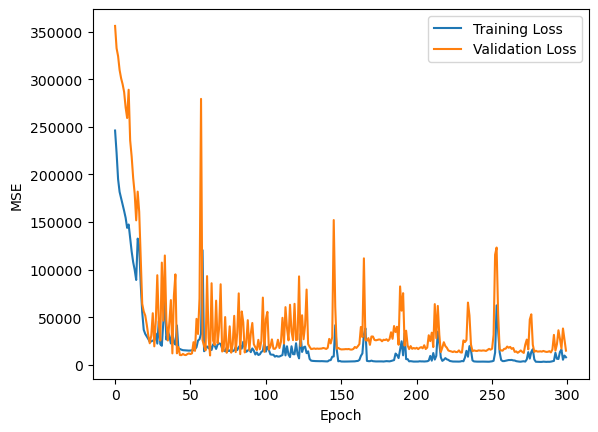

Best Validation MSE: 9775.6309
Best Validation R2: 0.9741
Best Epoch: 63
Test MSE: 6920.0073
Test R2: 0.9345


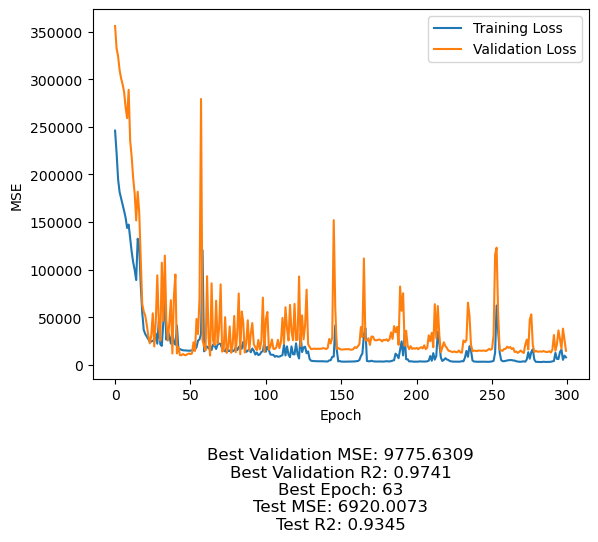

In [8]:

#now we will plot the learning curve

plt.plot(train_history, label='Training Loss')
plt.plot(val_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

print("Best Validation MSE: {:.4f}".format(best_mse))
print("Best Validation R2: {:.4f}".format(best_r2))
print("Best Epoch: {}".format(best_epoch))

#Now for the final step we will evaluate the model on the test data set which we have not used so far

mse, r2 = eval(model, X_test, Y_test)
print("Test MSE: {:.4f}".format(mse))
print("Test R2: {:.4f}".format(r2))

#make the same training and validation plots as before but now add as an inset the Best Validation MSE and Best Validation R2 and Best Epoch and Test MSE and Test R2

plt.plot(train_history, label='Training Loss')
plt.plot(val_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
#plot a box around the inset
#plt.gca().add_patch(plt.Rectangle((0.5, 0.3), 0.4, 0.4, linewidth=2, edgecolor='b', facecolor='none', zorder=10))
#inset
plt.text(0.5, -0.3, "Best Validation MSE: {:.4f}\nBest Validation R2: {:.4f}\nBest Epoch: {}\nTest MSE: {:.4f}\nTest R2: {:.4f}".format(best_mse, best_r2, best_epoch, mse, r2), fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)
#save the plot as a png file
#plt.savefig('learning_curve_with_sentiment_no_comments_21_epochs.png')
plt.show()


### Some plots from misc older runs 

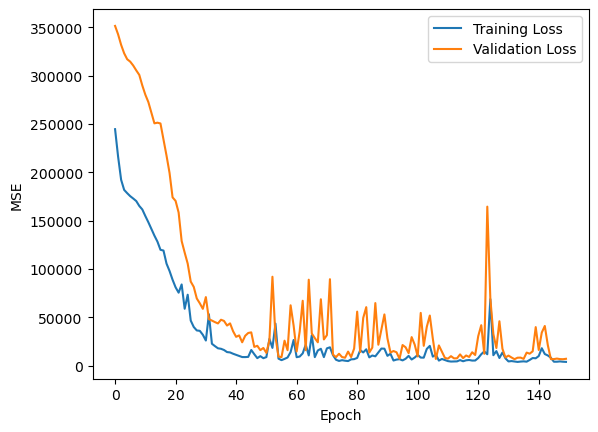

Best Validation MSE: 6687.7236
Best Validation R2: 0.9823
Best Epoch: 148
Test MSE: 5307.0776
Test R2: 0.9498


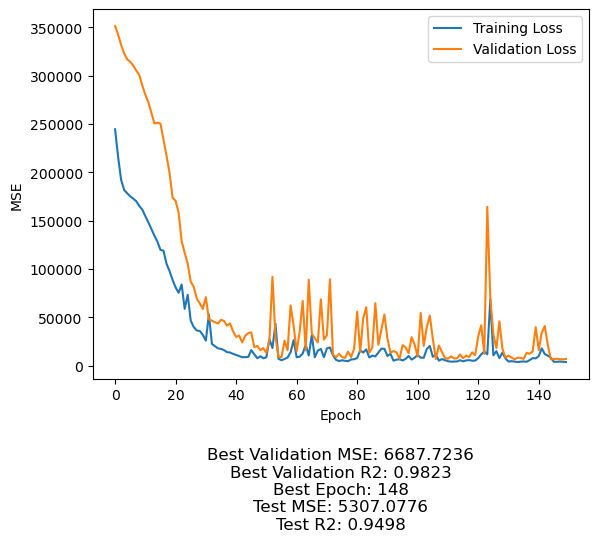

In [9]:

#now we will plot the learning curve (for 150 epchs)

plt.plot(train_history, label='Training Loss')
plt.plot(val_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

print("Best Validation MSE: {:.4f}".format(best_mse))
print("Best Validation R2: {:.4f}".format(best_r2))
print("Best Epoch: {}".format(best_epoch))

#Now for the final step we will evaluate the model on the test data set which we have not used so far

mse, r2 = eval(model, X_test, Y_test)
print("Test MSE: {:.4f}".format(mse))
print("Test R2: {:.4f}".format(r2))

#make the same training and validation plots as before but now add as an inset the Best Validation MSE and Best Validation R2 and Best Epoch and Test MSE and Test R2

plt.plot(train_history, label='Training Loss')
plt.plot(val_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
#plot a box around the inset
#plt.gca().add_patch(plt.Rectangle((0.5, 0.3), 0.4, 0.4, linewidth=2, edgecolor='b', facecolor='none', zorder=10))
#inset
plt.text(0.5, -0.3, "Best Validation MSE: {:.4f}\nBest Validation R2: {:.4f}\nBest Epoch: {}\nTest MSE: {:.4f}\nTest R2: {:.4f}".format(best_mse, best_r2, best_epoch, mse, r2), fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)
#save the plot as a png file
#plt.savefig('learning_curve_with_sentiment_no_comments_21_epochs.png')
plt.show()


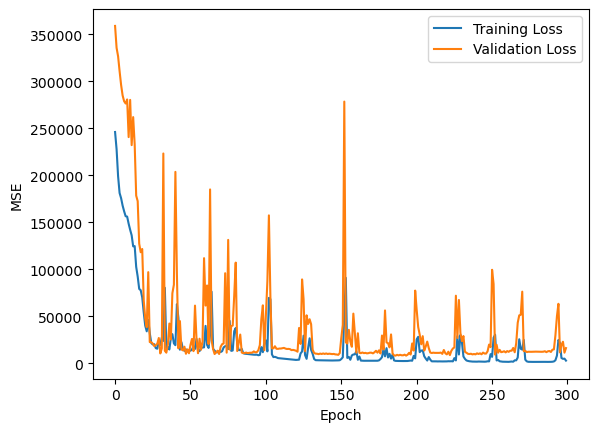

Best Validation MSE: 8246.0771
Best Validation R2: 0.9782
Best Epoch: 186
Test MSE: 9623.5215
Test R2: 0.9089


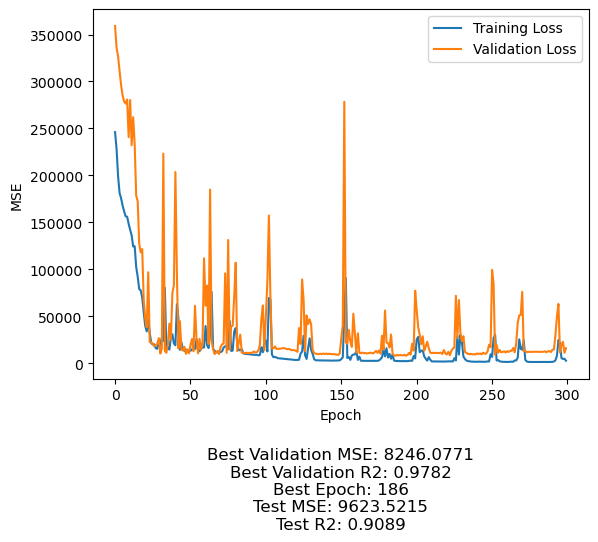

In [8]:

#now we will plot the learning curve

plt.plot(train_history, label='Training Loss')
plt.plot(val_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

print("Best Validation MSE: {:.4f}".format(best_mse))
print("Best Validation R2: {:.4f}".format(best_r2))
print("Best Epoch: {}".format(best_epoch))

#Now for the final step we will evaluate the model on the test data set which we have not used so far

mse, r2 = eval(model, X_test, Y_test)
print("Test MSE: {:.4f}".format(mse))
print("Test R2: {:.4f}".format(r2))

#make the same training and validation plots as before but now add as an inset the Best Validation MSE and Best Validation R2 and Best Epoch and Test MSE and Test R2

plt.plot(train_history, label='Training Loss')
plt.plot(val_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
#plot a box around the inset
#plt.gca().add_patch(plt.Rectangle((0.5, 0.3), 0.4, 0.4, linewidth=2, edgecolor='b', facecolor='none', zorder=10))
#inset
plt.text(0.5, -0.3, "Best Validation MSE: {:.4f}\nBest Validation R2: {:.4f}\nBest Epoch: {}\nTest MSE: {:.4f}\nTest R2: {:.4f}".format(best_mse, best_r2, best_epoch, mse, r2), fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)
#save the plot as a png file
#plt.savefig('learning_curve_with_sentiment_no_comments_21_epochs.png')
plt.show()


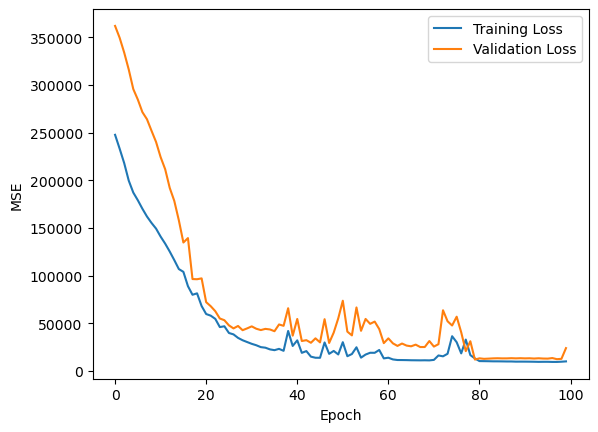

Best Validation MSE: 11832.1123
Best Validation R2: 0.9687
Best Epoch: 79


In [36]:
#now we will plot the learning curve

plt.plot(train_history, label='Training Loss')
plt.plot(val_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

print("Best Validation MSE: {:.4f}".format(best_mse))
print("Best Validation R2: {:.4f}".format(best_r2))
print("Best Epoch: {}".format(best_epoch))



In [37]:
#Now for the final step we will evaluate the model on the test data set which we have not used so far

mse, r2 = eval(model, X_test, Y_test)
print("Test MSE: {:.4f}".format(mse))
print("Test R2: {:.4f}".format(r2))


Test MSE: 23683.6602
Test R2: 0.7758
